# GAN - Testing Hyperparameters  

In order to test different Hyperparameters, we decided to work in a separate Jupyter Notebook.

| Teammember |                    |
|------------|--------------------|
| 1.         | Christopher Caldwell |
| 2.         | Fabian Müller      |
| 3.         | An Dang         |

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

### Setting up the Training Data

Since we want to test out two different activation functions at the end of the generator, we transformed the data twice. 
For the **Sigmoid Activation** we transformed the original 0 - 255 Image Data to map values between 0 and 1.  
For the **Tanh Activation** we transformed the original data to map Values between -1 and 1

In [3]:
from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y),(test_X, test_y) = load_data()


train_X_sig = train_X/255.0
train_y_sig = train_y/255.0

test_X_sig = test_X/255.0
test_y_sig = test_y/255.0



train_X_tanh = (train_X-127.5)/127.5
train_y_tanh = (train_y-127.5)/127.5



test_X_tanh = (test_X-127.5)/127.5
test_y_tanh = (test_y-127.5)/127.5


train_sig = np.append(train_X_sig, test_X_sig, axis=0) #Use both Train and Testset for GAN
train_tanh = np.append(train_X_tanh, test_X_tanh, axis=0) #Use both Train and Testsets from -1 to 1 for GAN with tanh





### Boolean Placeholders

In order to differentiate between the different models, we use Placeholders which will be fed with data at the training session according to the current model to be tested.  
We use Bool Placeholders to see if the current model want to use **Leaky Relu** Activation or the **Relu** activation function.  
We also use a boolean Placeholder to see if the current model wants to use the **tanh** activation function at the end of the generator or simply use the regular **sigmoid** activation function

In [3]:
with tf.name_scope('input'):
    leaky_relu = tf.placeholder(tf.bool, shape=(), name="UseLeakyRelu")
    tanh = tf.placeholder(tf.bool, shape=(), name="UseTanH")

In [4]:
def discriminator(X, reuse_vars=None):
    with tf.variable_scope('dis', reuse=reuse_vars):
        
        # Convolution Layer
        conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5,5], padding="same", name="conv1")
        
        
        # Differentiate between Leaky Relu and Relu
        if leaky_relu is True:
            conv1 = tf.nn.leaky_relu(conv1)
        else:
            conv1 = tf.nn.relu(conv1)
        
        # Pooling Layer
        pool1 = tf.layers.average_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, name="pool1")

        
        
        
        # Convolution Layer
        conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5,5], padding="same", name="conv2")
        
        # Differentiate between Leaky Relu and Relu
        if leaky_relu is True:
            conv2 = tf.nn.leaky_relu(conv2)
        else:
            conv2 = tf.nn.relu(conv2)
         
        # Pooling Layer
        pool2 = tf.layers.average_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, name="pool2")

        
        
        # Flatten
        flat_layer = tf.reshape(pool2, [-1, 7 * 7 * 64], name="flatten")

        
        
        
        # Dense layer
        dense = tf.layers.dense(inputs=flat_layer, units=1024, name="dense")
        
        # Differentiate between Leaky Relu and Relu
        if leaky_relu is True:
            dense = tf.nn.leaky_relu(dense)
        else:
            dense = tf.nn.relu(dense)
        
        
        # Logits layer
        logits = tf.layers.dense(inputs=dense, units=1, name="dense2")
        
        output = tf.sigmoid(logits, name="sigmoid")
        
        return output, logits



In [5]:
def gen(noise, reuse_vars=None):
    with tf.variable_scope("gen", reuse=reuse_vars):
        
        
        
        # First DenseLayer
        dense = tf.layers.dense(inputs=noise, units=3136, name="dense")
        
        # Differentiate between Leaky Relu and Relu
        if leaky_relu is True:
            dense = tf.nn.leaky_relu(dense)
        else:
            dense = tf.nn.relu(dense)
            

        #Reshape
        reshape = tf.reshape(dense, [-1, 56, 56, 1], name="reshape")

        
        
        #1 Conv2d
        conv1 = tf.layers.conv2d(inputs=reshape, filters=50, kernel_size=[3,3], strides=2, padding="same", name="conv1")

        # Differentiate between Leaky Relu and Relu
        if leaky_relu is True:
            conv1 = tf.nn.leaky_relu(conv1)
        else:
            conv1 = tf.nn.relu(conv1)
        
        
        #BatchNormalization
        conv1_norm = tf.layers.batch_normalization(conv1, name="batch_norm1")

        #Upsample
        conv1_upsample = tf.image.resize_images(conv1_norm, (56,56))


        #2 Conv2d
        conv2 = tf.layers.conv2d(inputs=conv1_upsample, filters=25, kernel_size=[3,3], strides=2, padding="same", name="conv2")

        # Differentiate between Leaky Relu and Relu
        if leaky_relu is True:
            conv2 = tf.nn.leaky_relu(conv2)
        else:
            conv2 = tf.nn.relu(conv2)
        
        
        #BatchNormalization
        conv2_norm = tf.layers.batch_normalization(conv2, name="batch_norm2")

        #Upsample
        conv2_upsample = tf.image.resize_images(conv2_norm, (56,56))


        #2 Conv2d
        logits = tf.layers.conv2d(inputs=conv2_upsample, filters=1, kernel_size=[3,3], strides=2, padding="same", name="conv3")
        
        # Differentiate between Tanh and Sigmoid Activation Function
        if tanh is True:
            output = tf.nn.tanh(logits, name="tanh")
        else:
            output = tf.nn.sigmoid(logits, name="sigmoid")
        
        return output


### Placeholder for Images and Noise

Adding Placeholders for Images and Random Noise

In [6]:
with tf.name_scope('input'):
    real_images = tf.placeholder(tf.float32, shape=[None, 28,28,1], name="ImagePlaceholder")
    z = tf.placeholder(tf.float32, shape=[None, 100], name = "NoisePlaceholder")

In [7]:
Gz = gen(z)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [8]:
D_output_real, D_logits_real = discriminator(real_images)
D_output_fake, D_logits_fake = discriminator(Gz, reuse_vars=True)

Instructions for updating:
Use keras.layers.average_pooling2d instead.


In [9]:
# LOSSES
def loss_func (logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_in, labels=labels_in, name="CrossEntropy"), name="ReduceMean")

### Adding Smoothing

Adding a smoothing Placeholder to multiply the Loss of the discrimintator with a factor  

$0.0 >= smoothing <= 1.0$

In [ ]:
SMOOTHING = tf.placeholder(tf.float32, name = "SmothingFactor")

D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real, name="Generator_Label")*SMOOTHING)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_fake, name="Discriminator_Label"))

D_loss = D_real_loss + D_fake_loss

In [11]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake, name="Generator_TrickLabel"))

In [12]:
D_learning_rate = tf.placeholder(tf.float32, name = "DiscriminatorLearningRate")
G_learning_rate = tf.placeholder(tf.float32, name = "GeneratorLearningRate")

In [13]:
d_vars = tf.trainable_variables(scope='dis')
g_vars = tf.trainable_variables(scope='gen')

In [14]:
D_trainer = tf.train.AdamOptimizer(D_learning_rate, name="AdamOptimizer_Discriminator").minimize(D_loss, var_list=d_vars)


Instructions for updating:
Use tf.cast instead.


In [15]:
G_trainer = tf.train.AdamOptimizer(G_learning_rate, name="AdamOptimizer_Discriminator").minimize(G_loss, var_list=g_vars, name="minimize_G_loss")

In [16]:
tf.summary.scalar("Dx_Loss", D_real_loss)
tf.summary.scalar("Dg_Loss", D_fake_loss)
tf.summary.scalar("D_loss", D_loss)
tf.summary.scalar("G_loss", G_loss)

tf.summary.image("Generated_Images", Gz, max_outputs=1)

<tf.Tensor 'Generated_Images:0' shape=() dtype=string>

In [17]:
import datetime

now = datetime.datetime.now()

### Placeholder for Batch Size

In order to differantiate between Models of different Batch Sizes, we first need to add a Placeholder for the Batch Size with the Format tf.int64 (to be iterable)

In [18]:
BATCH_SIZE = tf.placeholder(tf.int64, name = "BatchSizePlaceholder")
#BATCH_SIZE = 100

BUFFER_SIZE = 140000

IMAGES = 1000000



In [19]:
samples = []


In [20]:
merged = tf.summary.merge_all()

>*copied from the top*

In [ ]:
from tqdm import tqdm
from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y),(test_X, test_y) = load_data()

train_X_sig = train_X/255.0
train_y_sig = train_y/255.0

test_X_sig = test_X/255.0
test_y_sig = test_y/255.0



train_X_tanh = (train_X-127.5)/127.5
train_y_tanh = (train_y-127.5)/127.5



test_X_tanh = (test_X-127.5)/127.5
test_y_tanh = (test_y-127.5)/127.5


train_sig = np.append(train_X_sig, test_X_sig, axis=0) #Use both Train and Testset for GAN
train_tanh = np.append(train_X_tanh, test_X_tanh, axis=0) #Use both Train and Testsets from -1 to 1 for GAN with tanh

### Dataset and Iterator

In order to adjust the batch size, we needed to change the one shot iterator to an initializable iterator. We also provided to different Data Variables for the different Activation Functions at the end of the generator.  
**batchtrain** is for the sigmoid function.  
**batchtrain_tanh** is for the tanh function

In [ ]:
batchtrain = train_sig.reshape(train_sig.shape[0], 28, 28, 1).astype('float32')
batchtrain_tanh = train_tanh.reshape(train_tanh.shape[0], 28, 28, 1).astype('float32')

data = tf.placeholder(tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(data).repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
iterator = dataset.make_initializable_iterator()
nextbatch = iterator.get_next()

init = tf.global_variables_initializer()

### Different Models

To test out different models, we created a 2 dimensional array. Each index contains different modeltypes for a specific hyperparameter.

1. Batch Size (100 | 200)
Describes the Batch Size during the training process. 
2. Learning Rate (0.0001 | 0.00001)
Describes the Learning Rate for the Generator & Discriminator
3. Discriminator Learning Rate Multiplier (1 | 3)
With this parameter, we can multiply the learning rate of the discriminator a factor to achieve different learning rates for generator and discriminator.  
If this equals 1 -> Generator Learning Rate = Discriminator Learning Rate
If this is greater than 1 -> Discriminator is x times larger than generator
If this is between 0 and 1 -> Discriminator is a fraction of the generator
4. Smoothing (0.9 | 1)
This will Smooth the Discriminator Loss by the factor given. If the parameter = 1 -> No smoothing is applied
5. Leaky Relu (False | True)
This parameter switches between the use of Leaky Relu instad of Relu in the Generator as well as the Discriminator
6. Tanh (False | True)
This parameter switches between the use of tanh or simoid as the activation function for the logits of the generator
7. uniform Distribution (False, True)
This parameter switches between the use of uniform distributed random noise or normal distributed random noise

In a total we have 128 different models.

$ 2^{7} = 128$


Other parameters that we did not implement since the training time would take to long were:
*Text written in bold letters were used for the above models*

* Add Dropout to the models or **not**
* **Use Batch Normalization** or not
* **Pretrain the Discriminator** and specify how many images **(20000)** or not
* generate specific digits by including the datalabels or **generate random digits**



In [22]:
mode_batch_size = [100, 200]
mode_learning_rate = [0.0001,0.00001]
mode_disc_lr_multiplier = [1, 3]

mode_smoothing = [0.9, 1]
mode_leakyRelu = [False, True]
mode_tanh = [False, True]
mode_uniformDistribution = [False, True]


modes = []

for m_batch_size, m_learning_rate, m_disc_multiplier, m_smoothing, m_leaky, m_tanh, m_uniform in [(m_batch_size, m_learning_rate, m_disc_multiplier, m_smoothing, m_leaky, m_tanh, m_uniform) for m_batch_size in mode_batch_size for m_learning_rate in mode_learning_rate for m_disc_multiplier in mode_disc_lr_multiplier for m_smoothing in mode_smoothing for m_leaky in mode_leakyRelu for m_tanh in mode_tanh for m_uniform in mode_uniformDistribution]:
    mode = [m_batch_size, m_learning_rate, m_disc_multiplier, m_smoothing, m_leaky, m_tanh, m_uniform]
    modes.append(mode)
    
print(len(modes), "different models will be tested")

128 different models will be tested


In [4]:
#To see if the GPU is being used or not
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [ ]:
#Adding config for GPU - not using all of the GPUs Memory -> leading to crashes
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:37<02:39, 31.45it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.4475038
Discriminator-Fake-Loss: 0.13097405
Discriminator Loss: 0.57847786
Generator Loss: 2.3919954


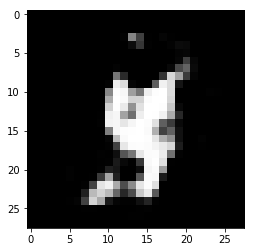

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:19<00:00, 30.98it/s]

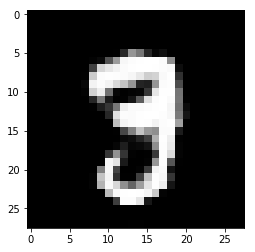

 50%|██████████████████████████████████████▍                                      | 4997/10000 [02:39<02:39, 31.43it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.42718858
Discriminator-Fake-Loss: 0.1234794
Discriminator Loss: 0.550668
Generator Loss: 2.9447675


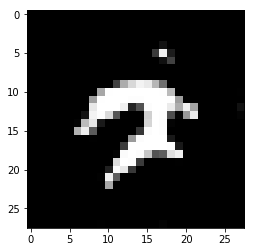

100%|████████████████████████████████████████████████████████████████████████████▉| 9997/10000 [05:19<00:00, 31.44it/s]

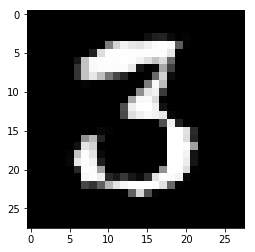

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.11it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.3250912
Discriminator-Fake-Loss: 1.5873852e-07
Discriminator Loss: 0.32509136
Generator Loss: 15.664355


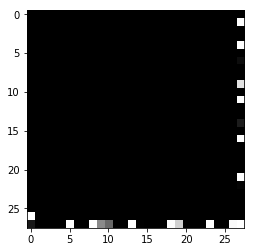

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.26it/s]

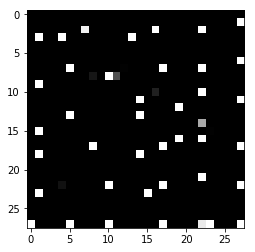

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:38<02:39, 31.46it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3250929
Discriminator-Fake-Loss: 1.1953298e-07
Discriminator Loss: 0.32509303
Generator Loss: 15.937418


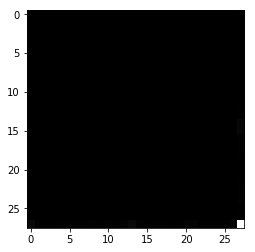

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:17<00:00, 31.42it/s]

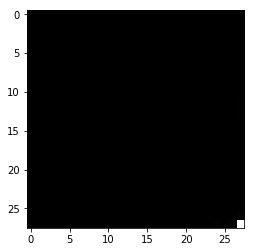

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.22it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.4695068
Discriminator-Fake-Loss: 0.12083577
Discriminator Loss: 0.5903426
Generator Loss: 2.7101727


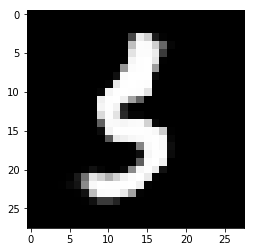

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.31it/s]

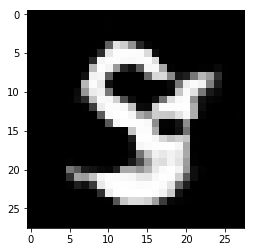

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:38, 31.59it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32549328
Discriminator-Fake-Loss: 3.928823e-05
Discriminator Loss: 0.32553256
Generator Loss: 10.186958


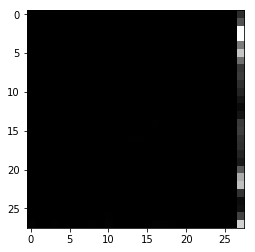

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:18<00:00, 31.62it/s]

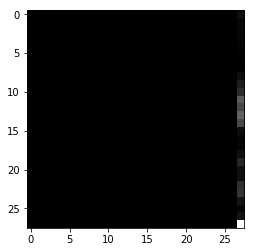

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.23it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32508677
Discriminator-Fake-Loss: 1.7167537e-07
Discriminator Loss: 0.32508695
Generator Loss: 15.576468


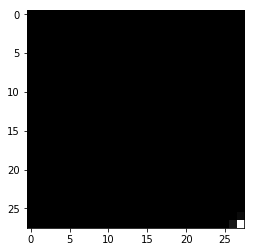

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.34it/s]

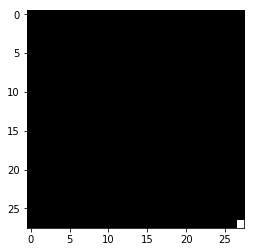

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.33it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32509336
Discriminator-Fake-Loss: 1.1867226e-07
Discriminator Loss: 0.32509348
Generator Loss: 15.9495325


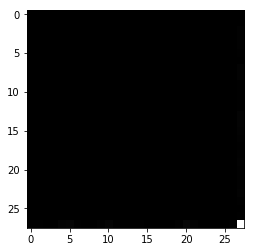

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.29it/s]

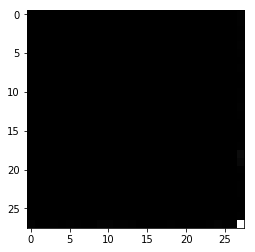

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:42, 30.75it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 4.1464884e-10
Discriminator-Fake-Loss: 6.63993e-07
Discriminator Loss: 6.6440765e-07
Generator Loss: 14.215222


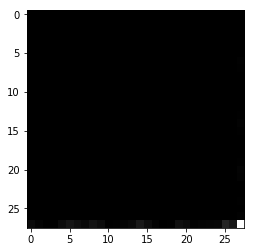

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.40it/s]

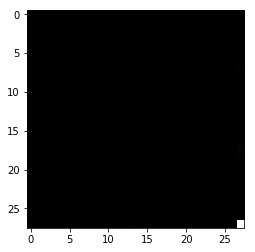

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.21it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 7.5537425e-09
Discriminator-Fake-Loss: 5.12213e-07
Discriminator Loss: 5.1976673e-07
Generator Loss: 14.485429


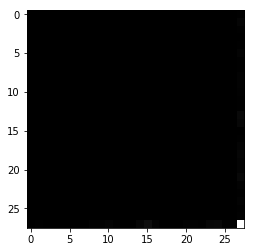

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:18<00:00, 31.47it/s]

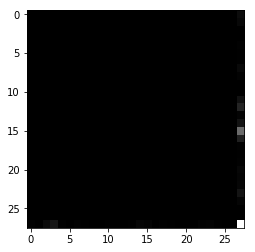

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.23it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 5.504935e-16
Discriminator-Fake-Loss: 1.7752531e-07
Discriminator Loss: 1.7752531e-07
Generator Loss: 15.544809


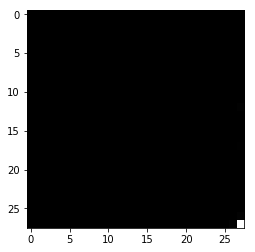

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:21<00:00, 31.31it/s]

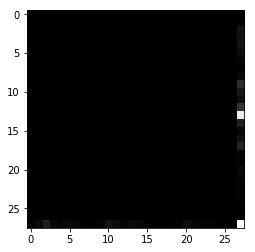

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:41, 31.08it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.8422563e-14
Discriminator-Fake-Loss: 1.9597435e-07
Discriminator Loss: 1.9597437e-07
Generator Loss: 15.445989


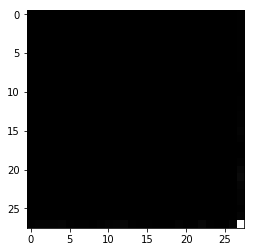

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.09it/s]

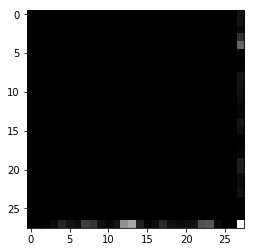

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 30.96it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.09591653
Discriminator-Fake-Loss: 0.13392311
Discriminator Loss: 0.22983965
Generator Loss: 3.026294


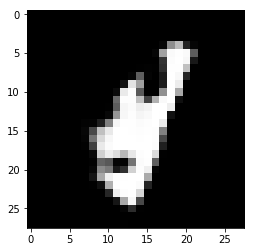

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.16it/s]

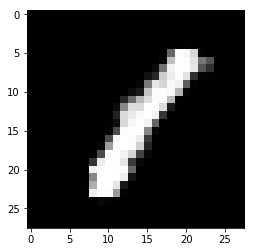

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.37it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.9532133e-10
Discriminator-Fake-Loss: 6.0637444e-07
Discriminator Loss: 6.067698e-07
Generator Loss: 14.315381


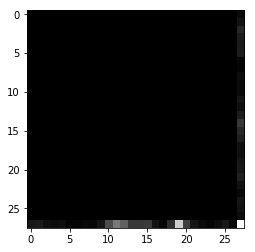

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.13it/s]

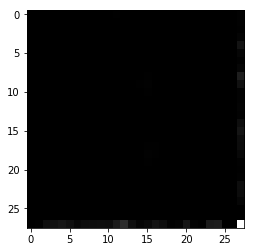

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:42, 30.85it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 8.7157133e-16
Discriminator-Fake-Loss: 1.2429052e-07
Discriminator Loss: 1.2429052e-07
Generator Loss: 15.901295


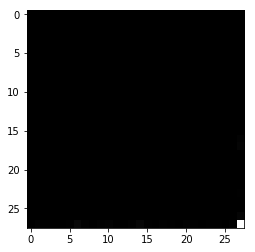

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.38it/s]

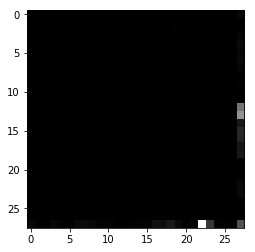

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.21it/s]

MODEL VERSION
100-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 7.6203215e-13
Discriminator-Fake-Loss: 1.1035734e-07
Discriminator Loss: 1.103581e-07
Generator Loss: 16.020082


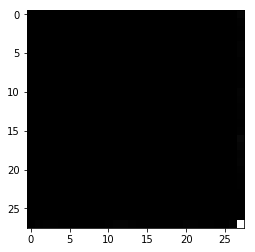

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:18<00:00, 31.50it/s]

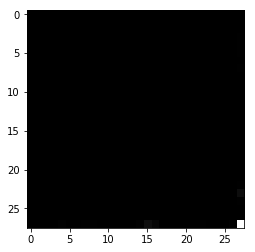

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.37it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.36224696
Discriminator-Fake-Loss: 0.07472157
Discriminator Loss: 0.43696854
Generator Loss: 3.470447


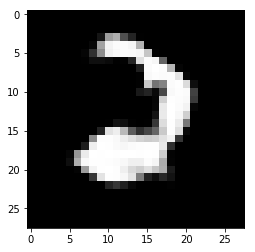

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.21it/s]

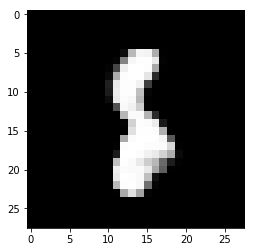

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:38<02:39, 31.46it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32508945
Discriminator-Fake-Loss: 1.159463e-06
Discriminator Loss: 0.32509062
Generator Loss: 13.671008


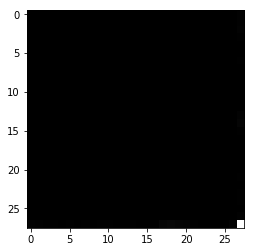

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:18<00:00, 31.34it/s]

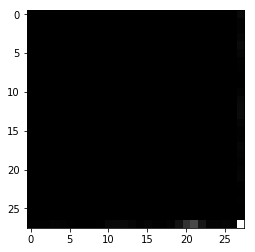

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.41it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32508615
Discriminator-Fake-Loss: 3.7985625e-08
Discriminator Loss: 0.32508618
Generator Loss: 17.08536


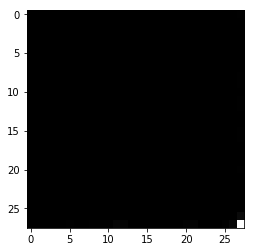

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.39it/s]

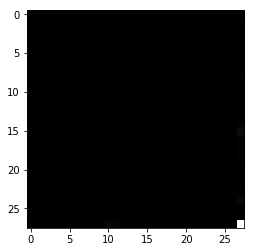

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.29it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3250845
Discriminator-Fake-Loss: 2.3071072e-08
Discriminator Loss: 0.32508454
Generator Loss: 17.585342


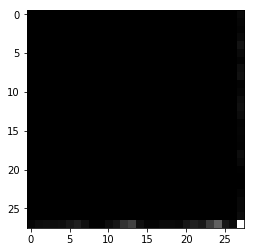

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.76it/s]

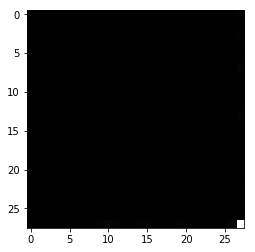

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.28it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32510903
Discriminator-Fake-Loss: 1.18847165e-05
Discriminator Loss: 0.32512093
Generator Loss: 11.356085


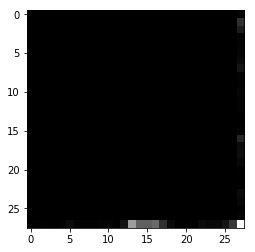

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.39it/s]

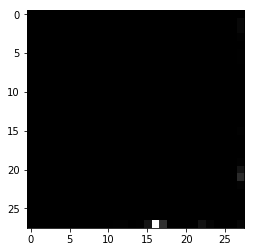

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.22it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32512677
Discriminator-Fake-Loss: 4.6266587e-06
Discriminator Loss: 0.3251314
Generator Loss: 12.270705


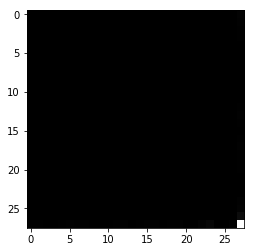

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:18<00:00, 31.60it/s]

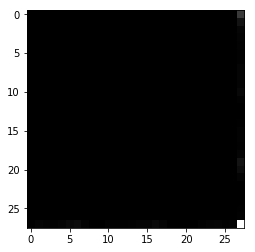

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:42, 30.73it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32510984
Discriminator-Fake-Loss: 2.6097942e-08
Discriminator Loss: 0.32510987
Generator Loss: 17.46508


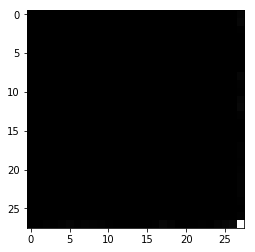

100%|████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [05:21<00:00, 31.28it/s]

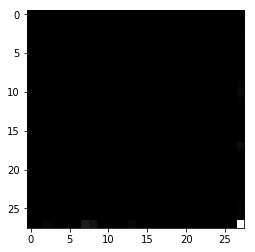

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:38, 31.67it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3250907
Discriminator-Fake-Loss: 2.8978492e-08
Discriminator Loss: 0.32509074
Generator Loss: 17.359522


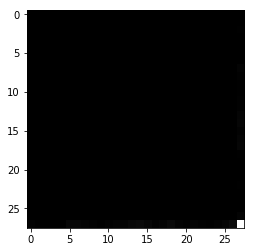

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:18<00:00, 31.42it/s]

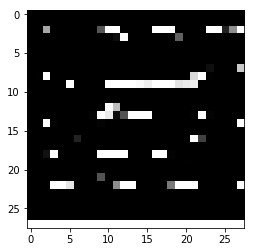

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.43it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 7.6048915e-12
Discriminator-Fake-Loss: 4.2953648e-08
Discriminator Loss: 4.2961254e-08
Generator Loss: 16.96431


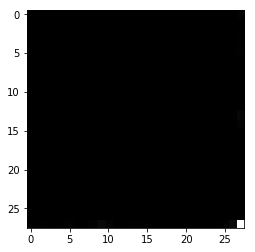

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.23it/s]

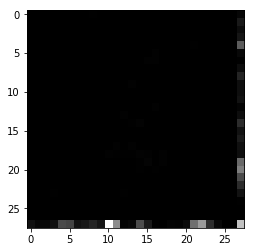

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.08it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.3439286e-11
Discriminator-Fake-Loss: 8.2458584e-08
Discriminator Loss: 8.249202e-08
Generator Loss: 16.312536


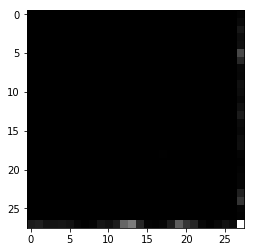

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.37it/s]

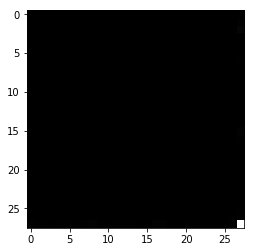

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:41, 31.06it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.3697059e-28
Discriminator-Fake-Loss: 2.9439107e-08
Discriminator Loss: 2.9439107e-08
Generator Loss: 17.341562


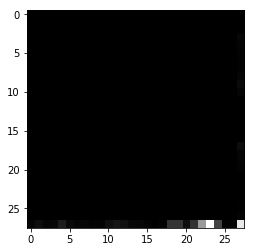

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.10it/s]

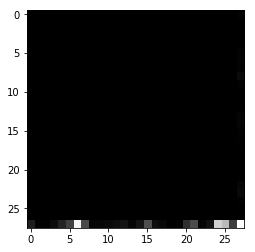

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.42it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.6685035e-30
Discriminator-Fake-Loss: 2.8859746e-09
Discriminator Loss: 2.8859746e-09
Generator Loss: 19.663975


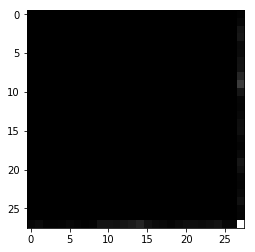

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.22it/s]

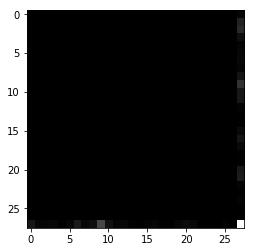

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 31.06it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 4.1424095e-12
Discriminator-Fake-Loss: 1.2188536e-07
Discriminator Loss: 1.218895e-07
Generator Loss: 15.924021


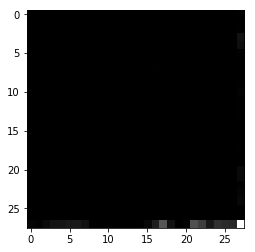

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.05it/s]

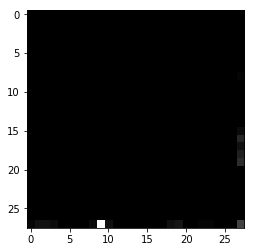

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.34it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 2.6939945e-10
Discriminator-Fake-Loss: 1.0097616e-07
Discriminator Loss: 1.0124556e-07
Generator Loss: 16.110256


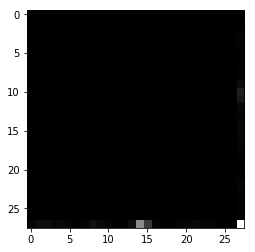

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 30.76it/s]

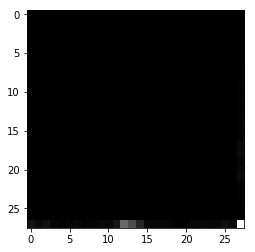

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.16it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.0
Discriminator-Fake-Loss: 1.8210531e-09
Discriminator Loss: 1.8210531e-09
Generator Loss: 20.124422


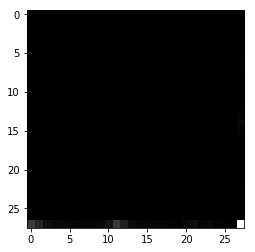

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.37it/s]

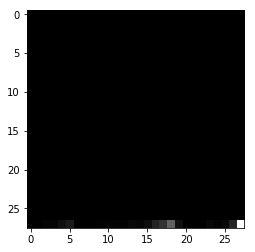

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:38, 31.48it/s]

MODEL VERSION
100-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 7.718184e-25
Discriminator-Fake-Loss: 6.1443126e-09
Discriminator Loss: 6.1443126e-09
Generator Loss: 18.908167


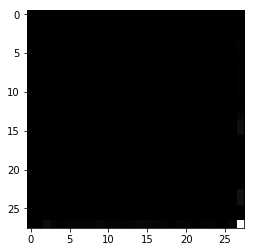

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.45it/s]

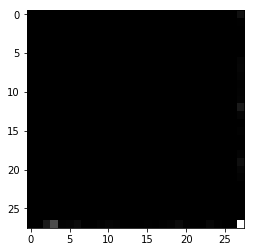

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.10it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32969868
Discriminator-Fake-Loss: 0.0017631182
Discriminator Loss: 0.3314618
Generator Loss: 6.33958


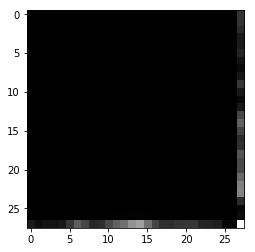

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.24it/s]

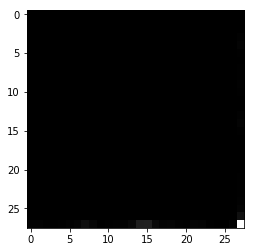

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.44it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.33349782
Discriminator-Fake-Loss: 0.0014978423
Discriminator Loss: 0.33499566
Generator Loss: 6.503131


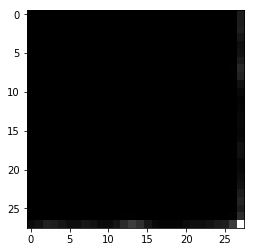

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:20<00:00, 31.42it/s]

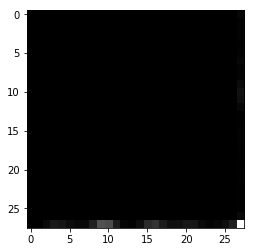

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 31.04it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32509965
Discriminator-Fake-Loss: 3.1873096e-05
Discriminator Loss: 0.3251315
Generator Loss: 10.354822


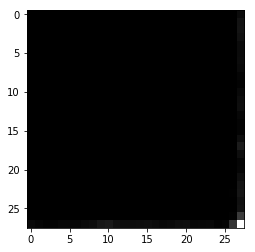

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.15it/s]

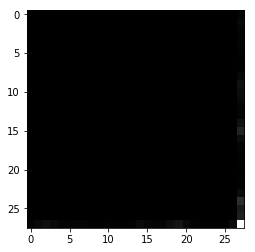

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.14it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32509667
Discriminator-Fake-Loss: 2.7484375e-05
Discriminator Loss: 0.32512414
Generator Loss: 10.503037


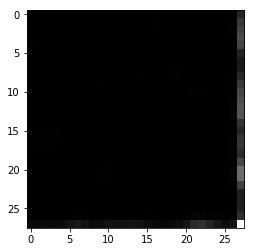

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.47it/s]

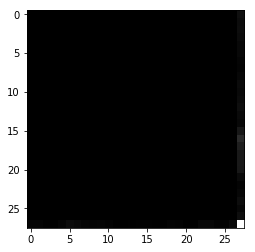

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 30.99it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.33160675
Discriminator-Fake-Loss: 0.0020280748
Discriminator Loss: 0.33363482
Generator Loss: 6.205517


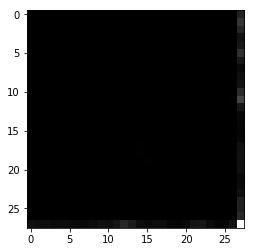

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.03it/s]

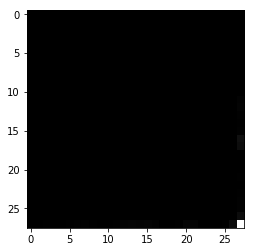

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:40, 31.24it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.331318
Discriminator-Fake-Loss: 0.0019714485
Discriminator Loss: 0.33328944
Generator Loss: 6.2488985


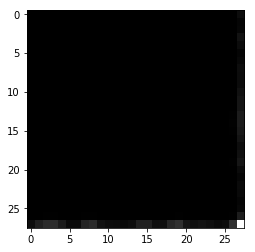

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.20it/s]

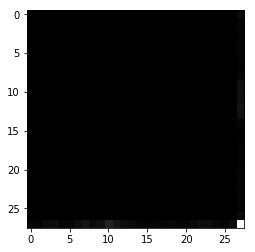

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 31.06it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.3250926
Discriminator-Fake-Loss: 2.352461e-05
Discriminator Loss: 0.32511613
Generator Loss: 10.65852


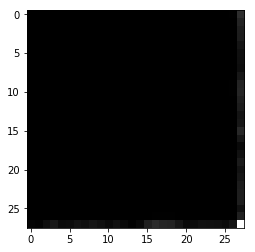

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 30.94it/s]

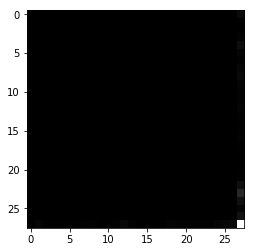

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.46it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32509822
Discriminator-Fake-Loss: 2.0534626e-05
Discriminator Loss: 0.32511875
Generator Loss: 10.79416


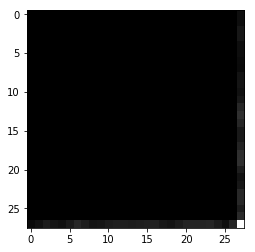

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.62it/s]

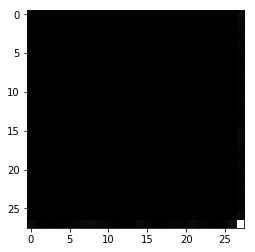

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.35it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.1091341e-06
Discriminator-Fake-Loss: 6.9601694e-05
Discriminator Loss: 7.171083e-05
Generator Loss: 9.573546


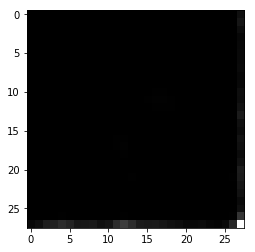

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.11it/s]

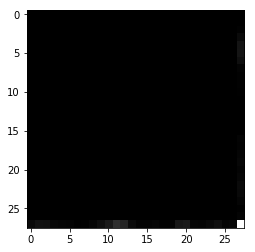

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:41, 31.04it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.1264717e-05
Discriminator-Fake-Loss: 7.9156955e-05
Discriminator Loss: 0.00011042167
Generator Loss: 9.444891


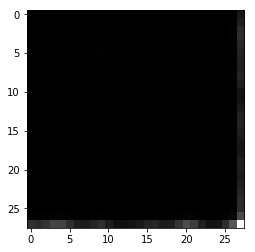

100%|████████████████████████████████████████████████████████████████████████████▉| 9997/10000 [05:20<00:00, 31.41it/s]

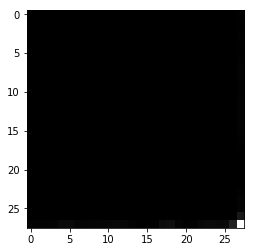

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:42, 30.85it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 7.6783996e-11
Discriminator-Fake-Loss: 2.1392781e-05
Discriminator Loss: 2.1392858e-05
Generator Loss: 10.753375


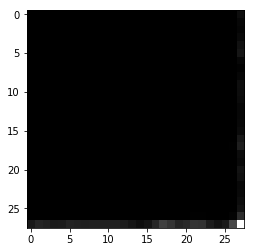

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:21<00:00, 31.08it/s]

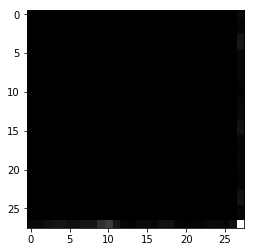

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:41, 30.93it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.2624151e-11
Discriminator-Fake-Loss: 2.4999434e-05
Discriminator Loss: 2.4999446e-05
Generator Loss: 10.597611


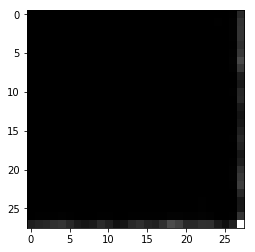

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:19<00:00, 31.31it/s]

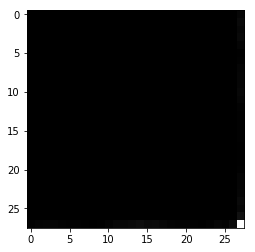

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:43, 30.69it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 4.552325e-07
Discriminator-Fake-Loss: 6.848912e-05
Discriminator Loss: 6.8944355e-05
Generator Loss: 9.590054


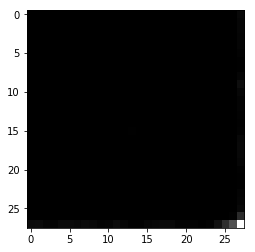

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.21it/s]

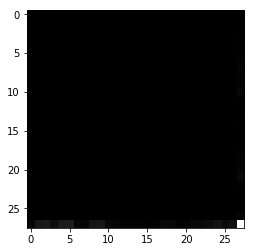

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:41, 31.07it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.6970687e-05
Discriminator-Fake-Loss: 6.525929e-05
Discriminator Loss: 0.000102229984
Generator Loss: 9.638254


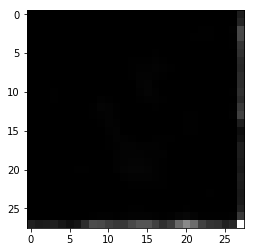

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.47it/s]

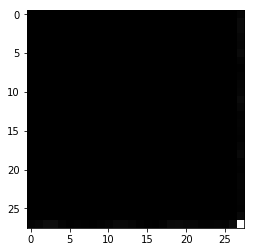

 50%|██████████████████████████████████████▍                                      | 4999/10000 [02:40<02:41, 31.05it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 9.899297e-13
Discriminator-Fake-Loss: 2.6150341e-05
Discriminator Loss: 2.6150343e-05
Generator Loss: 10.552607


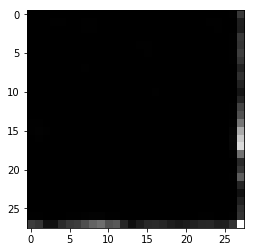

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:22<00:00, 31.09it/s]

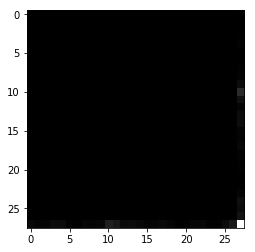

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.40it/s]

MODEL VERSION
100-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 2.2829592e-10
Discriminator-Fake-Loss: 2.0929836e-05
Discriminator Loss: 2.0930065e-05
Generator Loss: 10.775256


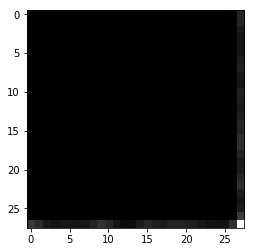

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.40it/s]

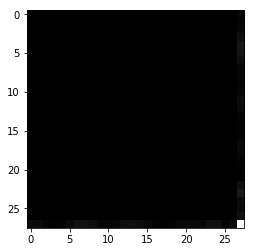

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:40, 31.13it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32731298
Discriminator-Fake-Loss: 0.0005555349
Discriminator Loss: 0.32786852
Generator Loss: 7.500227


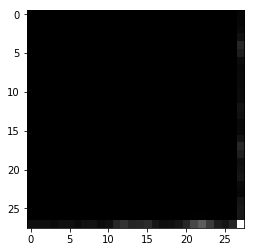

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:23<00:00, 30.95it/s]

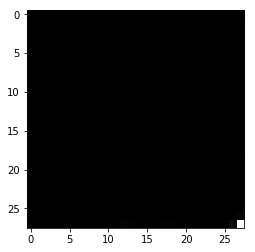

 50%|██████████████████████████████████████▍                                      | 4999/10000 [02:41<02:39, 31.29it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3280524
Discriminator-Fake-Loss: 0.0006062502
Discriminator Loss: 0.32865864
Generator Loss: 7.422621


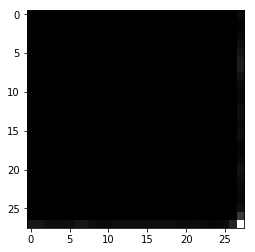

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:22<00:00, 31.23it/s]

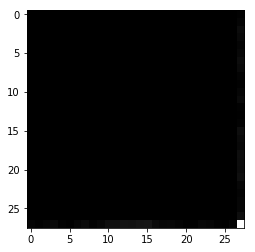

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.24it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32508618
Discriminator-Fake-Loss: 9.597683e-07
Discriminator Loss: 0.32508713
Generator Loss: 13.857364


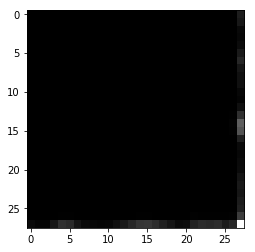

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 30.68it/s]

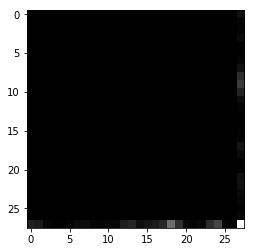

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 30.95it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32509148
Discriminator-Fake-Loss: 1.4984372e-06
Discriminator Loss: 0.32509297
Generator Loss: 13.4124


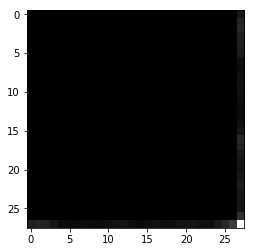

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.29it/s]

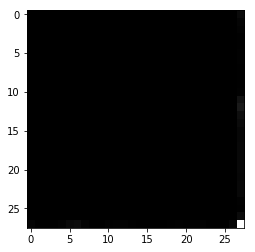

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.20it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32667857
Discriminator-Fake-Loss: 0.00057711883
Discriminator Loss: 0.3272557
Generator Loss: 7.476207


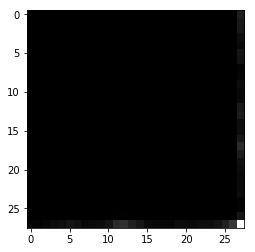

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.11it/s]

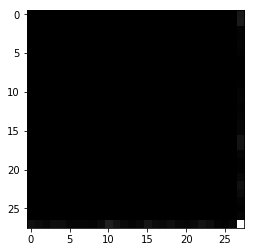

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:39, 31.32it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32746872
Discriminator-Fake-Loss: 0.000516416
Discriminator Loss: 0.32798514
Generator Loss: 7.578563


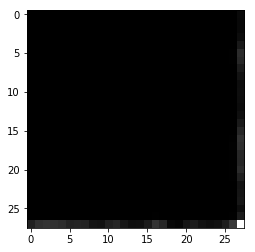

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.21it/s]

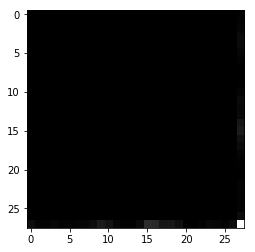

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:42, 30.86it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32508907
Discriminator-Fake-Loss: 1.2752172e-06
Discriminator Loss: 0.32509035
Generator Loss: 13.573922


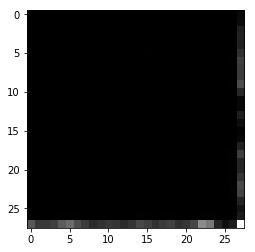

100%|████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [05:22<00:00, 31.12it/s]

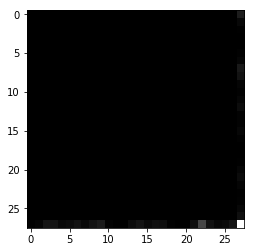

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.17it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3251038
Discriminator-Fake-Loss: 1.1923012e-06
Discriminator Loss: 0.32510498
Generator Loss: 13.639112


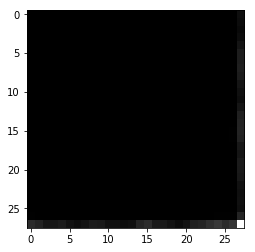

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.31it/s]

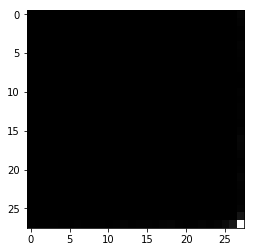

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:41, 31.05it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 1.1688396e-08
Discriminator-Fake-Loss: 5.882129e-06
Discriminator Loss: 5.893817e-06
Generator Loss: 12.0443535


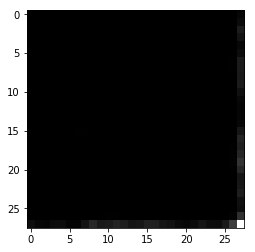

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:23<00:00, 30.98it/s]

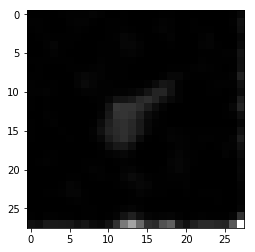

 50%|██████████████████████████████████████▍                                      | 4999/10000 [02:40<02:40, 31.22it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 5.3302433e-06
Discriminator-Fake-Loss: 6.285353e-06
Discriminator Loss: 1.1615596e-05
Generator Loss: 11.978498


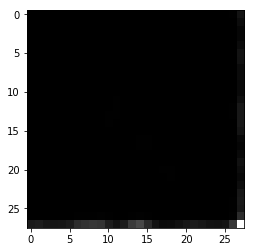

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:21<00:00, 31.29it/s]

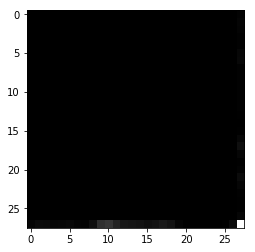

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:40, 31.13it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 6.5693604e-13
Discriminator-Fake-Loss: 1.3842599e-06
Discriminator Loss: 1.3842606e-06
Generator Loss: 13.491436


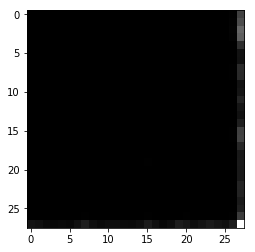

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.14it/s]

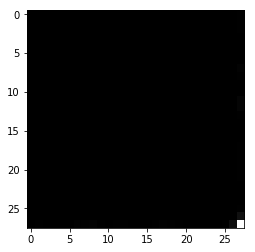

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:40, 31.10it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 7.196197e-14
Discriminator-Fake-Loss: 1.2957657e-06
Discriminator Loss: 1.2957659e-06
Generator Loss: 13.557323


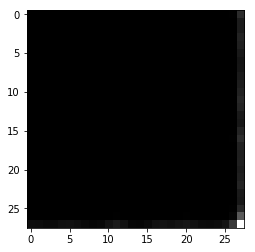

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.31it/s]

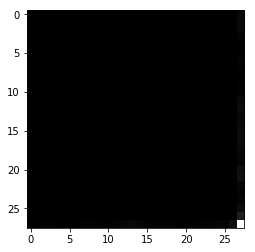

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:40, 31.18it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 4.7270365e-09
Discriminator-Fake-Loss: 5.882959e-06
Discriminator Loss: 5.8876863e-06
Generator Loss: 12.044952


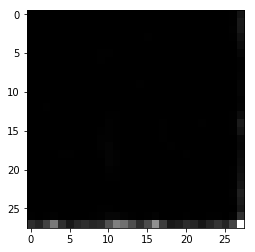

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:22<00:00, 31.07it/s]

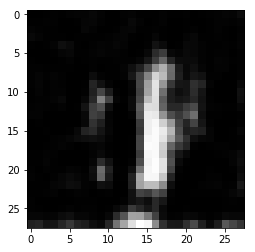

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:40<02:41, 30.89it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 6.296934e-07
Discriminator-Fake-Loss: 7.437316e-06
Discriminator Loss: 8.06701e-06
Generator Loss: 11.804015


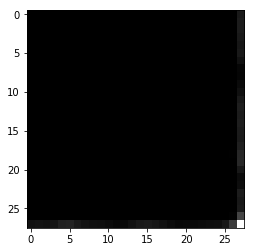

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:20<00:00, 31.15it/s]

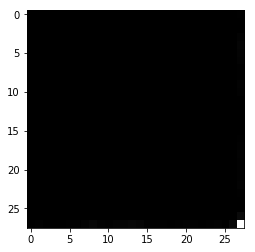

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:41<02:43, 30.54it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.2531312e-13
Discriminator-Fake-Loss: 1.3433072e-06
Discriminator Loss: 1.3433074e-06
Generator Loss: 13.521256


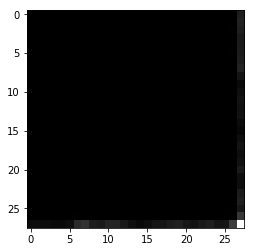

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [05:22<00:00, 31.08it/s]

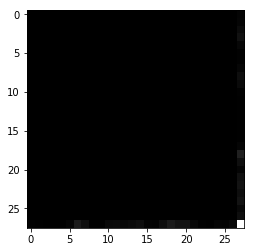

 50%|██████████████████████████████████████▍                                      | 4996/10000 [02:39<02:39, 31.45it/s]

MODEL VERSION
100-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.627724e-16
Discriminator-Fake-Loss: 1.8413359e-06
Discriminator Loss: 1.8413359e-06
Generator Loss: 13.205896


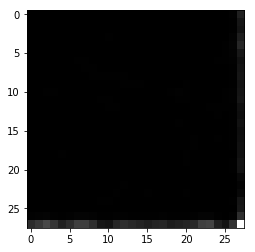

100%|████████████████████████████████████████████████████████████████████████████▉| 9997/10000 [05:20<00:00, 30.85it/s]

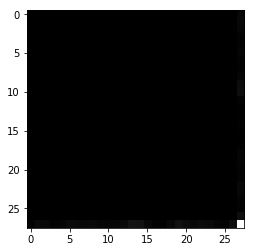

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.70it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.326805
Discriminator-Fake-Loss: 0.00038141222
Discriminator Loss: 0.3271864
Generator Loss: 7.8764567


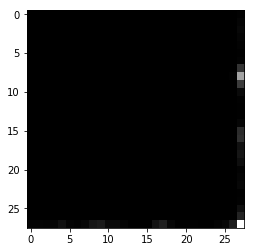

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.37it/s]

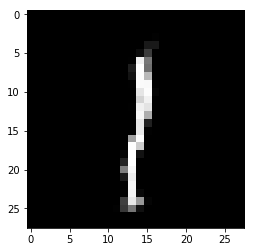

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:20, 17.84it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32622164
Discriminator-Fake-Loss: 0.00022009901
Discriminator Loss: 0.32644174
Generator Loss: 8.420658


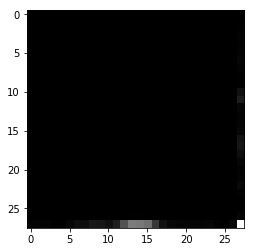

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.49it/s]

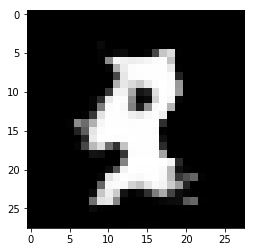

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.68it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32508737
Discriminator-Fake-Loss: 1.7467104e-06
Discriminator Loss: 0.32508913
Generator Loss: 13.25968


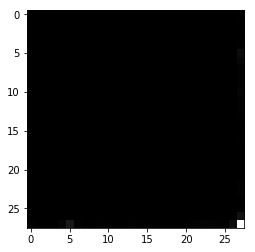

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.61it/s]

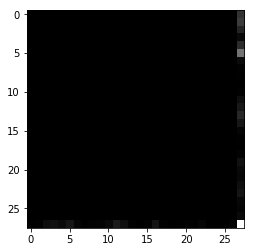

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.61it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32509
Discriminator-Fake-Loss: 1.253421e-06
Discriminator Loss: 0.32509124
Generator Loss: 13.592207


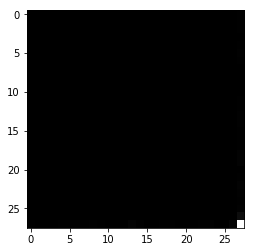

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.89it/s]

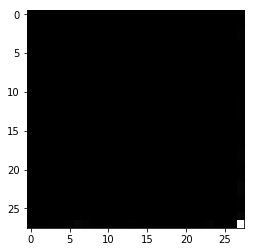

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.66it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32579163
Discriminator-Fake-Loss: 0.00017513685
Discriminator Loss: 0.32596678
Generator Loss: 8.676479


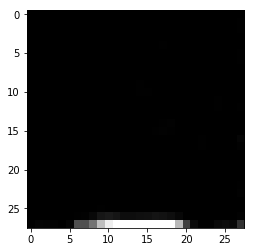

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.80it/s]

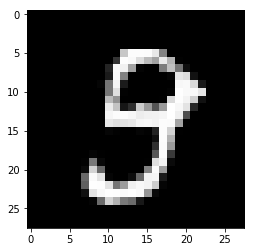

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.60it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32687873
Discriminator-Fake-Loss: 0.00048205644
Discriminator Loss: 0.32736078
Generator Loss: 7.664978


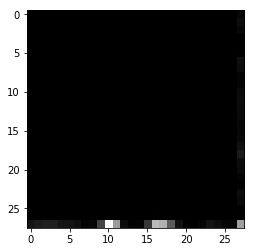

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.69it/s]

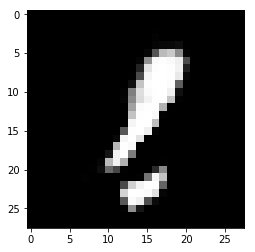

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:25, 17.23it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32508847
Discriminator-Fake-Loss: 7.378423e-07
Discriminator Loss: 0.32508922
Generator Loss: 14.122258


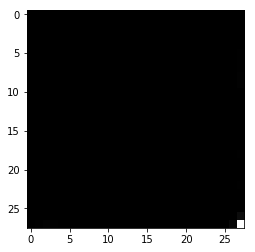

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.42it/s]

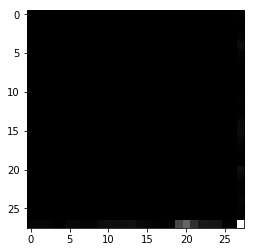

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.74it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32508767
Discriminator-Fake-Loss: 7.348344e-07
Discriminator Loss: 0.3250884
Generator Loss: 14.125075


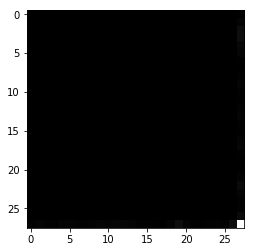

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.54it/s]

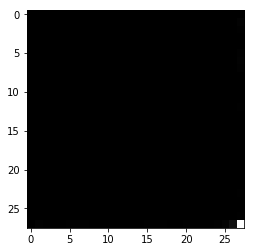

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:24, 17.33it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 4.6197897e-07
Discriminator-Fake-Loss: 3.7294915e-06
Discriminator Loss: 4.1914705e-06
Generator Loss: 12.496983


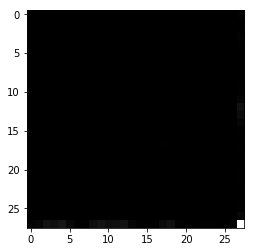

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.69it/s]

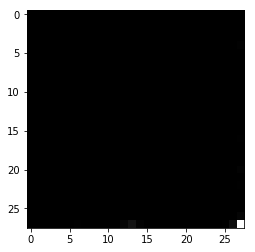

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.69it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 6.007747e-07
Discriminator-Fake-Loss: 4.285285e-06
Discriminator Loss: 4.8860593e-06
Generator Loss: 12.361629


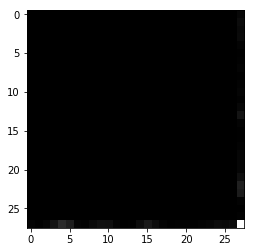

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.66it/s]

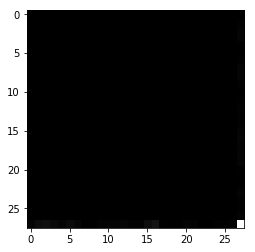

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:29, 16.77it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 6.8356444e-15
Discriminator-Fake-Loss: 1.0427771e-06
Discriminator Loss: 1.0427771e-06
Generator Loss: 13.774552


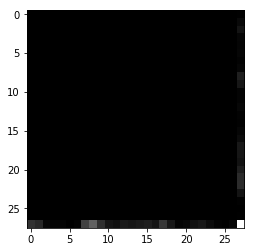

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.27it/s]

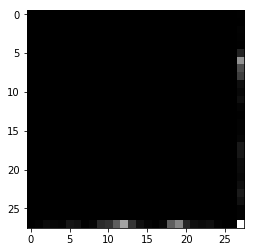

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.57it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 5.815117e-16
Discriminator-Fake-Loss: 4.783729e-07
Discriminator Loss: 4.783729e-07
Generator Loss: 14.553479


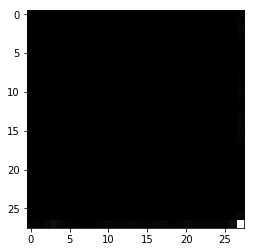

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.67it/s]

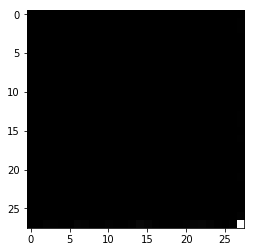

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.47it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.4007475e-06
Discriminator-Fake-Loss: 5.6463177e-06
Discriminator Loss: 8.047065e-06
Generator Loss: 12.085441


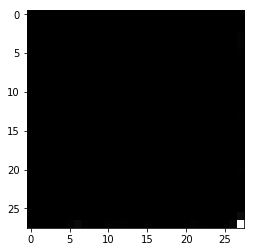

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.49it/s]

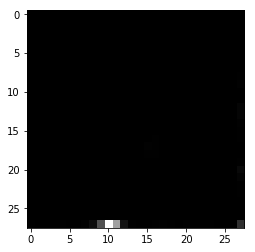

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.70it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.9203986e-08
Discriminator-Fake-Loss: 5.458319e-06
Discriminator Loss: 5.477523e-06
Generator Loss: 12.121424


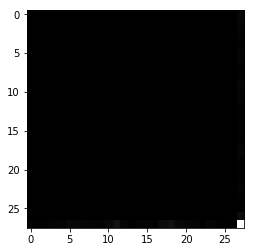

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.58it/s]

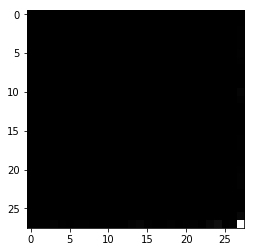

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.50it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.8230511e-15
Discriminator-Fake-Loss: 1.1917224e-06
Discriminator Loss: 1.1917224e-06
Generator Loss: 13.641079


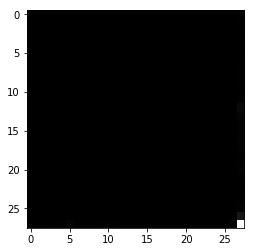

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.70it/s]

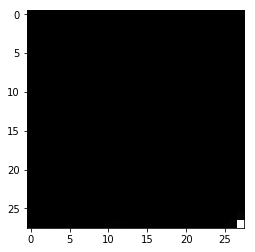

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.59it/s]

MODEL VERSION
200-batchsize_0.0001-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 5.8819716e-14
Discriminator-Fake-Loss: 1.5839718e-06
Discriminator Loss: 1.5839719e-06
Generator Loss: 13.356711


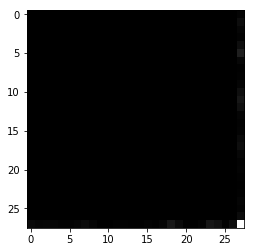

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.66it/s]

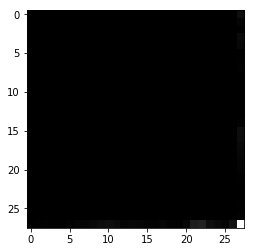

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.67it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32516128
Discriminator-Fake-Loss: 7.875797e-06
Discriminator Loss: 0.32516915
Generator Loss: 11.751287


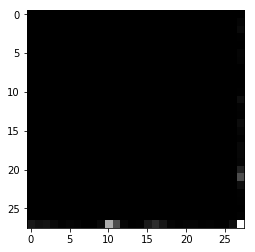

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.76it/s]

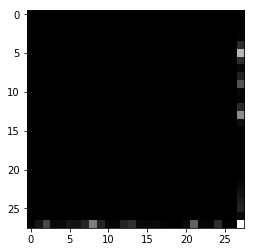

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:23, 17.49it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3254097
Discriminator-Fake-Loss: 1.789896e-05
Discriminator Loss: 0.32542762
Generator Loss: 10.934975


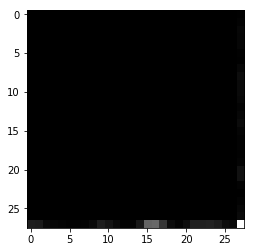

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.57it/s]

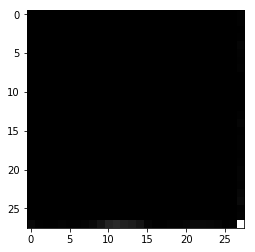

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.50it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.3250863
Discriminator-Fake-Loss: 9.69043e-08
Discriminator Loss: 0.32508639
Generator Loss: 16.150192


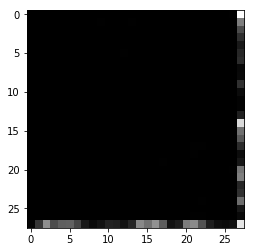

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.47it/s]

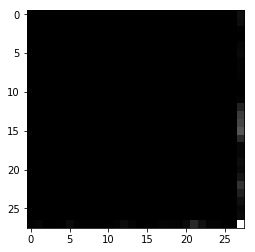

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.60it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3251013
Discriminator-Fake-Loss: 9.356095e-08
Discriminator Loss: 0.32510138
Generator Loss: 16.187393


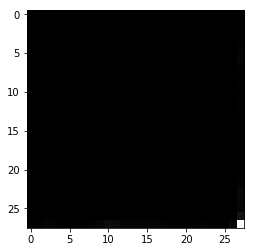

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.61it/s]

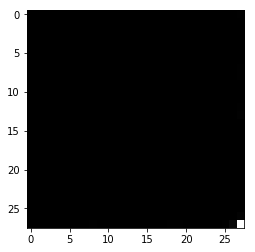

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.49it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32530963
Discriminator-Fake-Loss: 3.2797692e-05
Discriminator Loss: 0.32534245
Generator Loss: 10.336032


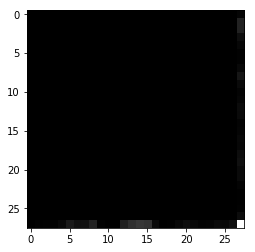

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.55it/s]

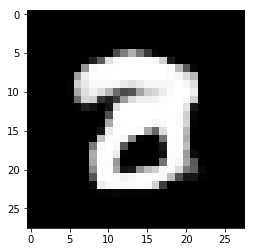

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.73it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3252114
Discriminator-Fake-Loss: 6.532874e-06
Discriminator Loss: 0.32521793
Generator Loss: 11.927844


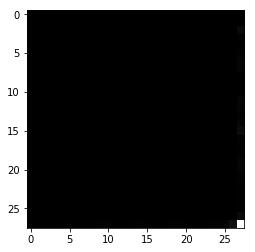

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.91it/s]

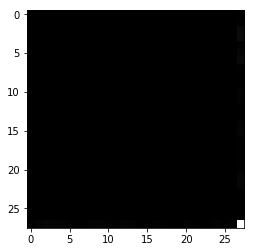

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.71it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32510555
Discriminator-Fake-Loss: 9.630885e-08
Discriminator Loss: 0.32510564
Generator Loss: 16.149273


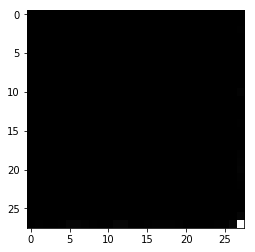

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.33it/s]

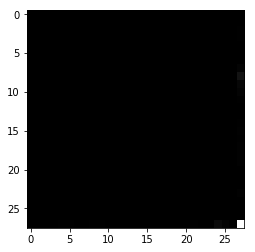

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.60it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32508668
Discriminator-Fake-Loss: 8.9779896e-08
Discriminator Loss: 0.32508677
Generator Loss: 16.226513


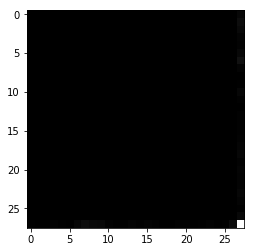

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.48it/s]

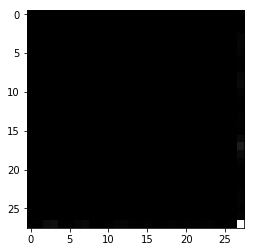

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:27, 16.98it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 1.0474989e-07
Discriminator-Fake-Loss: 5.7363343e-07
Discriminator Loss: 6.7838334e-07
Generator Loss: 14.3721285


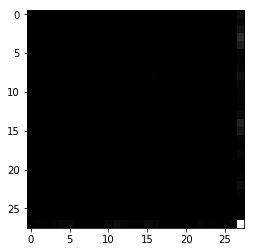

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 16.83it/s]

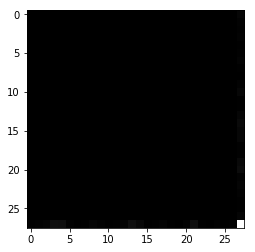

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.74it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.270067e-10
Discriminator-Fake-Loss: 5.091209e-07
Discriminator Loss: 5.0944794e-07
Generator Loss: 14.491355


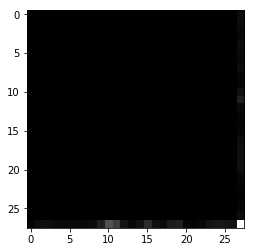

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.65it/s]

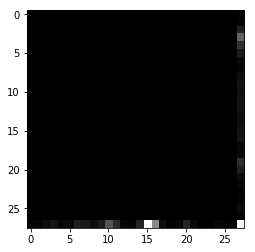

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.68it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.456814e-35
Discriminator-Fake-Loss: 9.386256e-08
Discriminator Loss: 9.386256e-08
Generator Loss: 16.18234


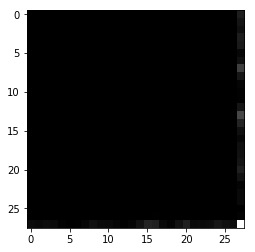

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.62it/s]

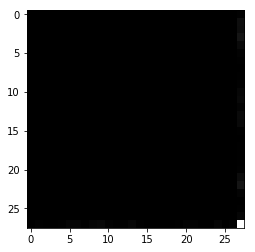

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.61it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 9.859353e-27
Discriminator-Fake-Loss: 1.7986682e-08
Discriminator Loss: 1.7986682e-08
Generator Loss: 17.834705


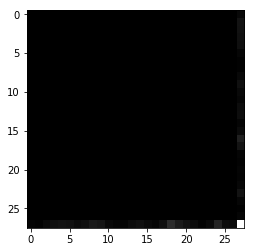

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.62it/s]

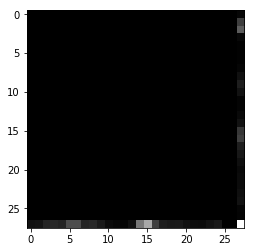

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.38it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.6891721e-11
Discriminator-Fake-Loss: 4.2213713e-07
Discriminator Loss: 4.2216402e-07
Generator Loss: 14.678847


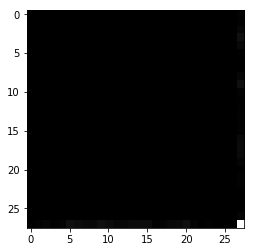

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.73it/s]

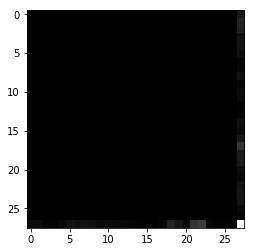

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:20, 17.84it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 8.5577023e-10
Discriminator-Fake-Loss: 6.3569803e-07
Discriminator Loss: 6.365538e-07
Generator Loss: 14.269944


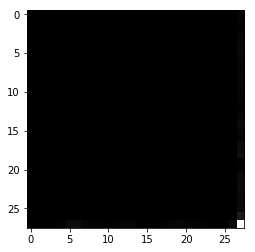

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.51it/s]

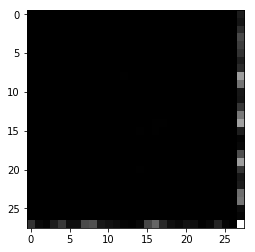

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.70it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 8.892427e-28
Discriminator-Fake-Loss: 7.370529e-09
Discriminator Loss: 7.370529e-09
Generator Loss: 18.727043


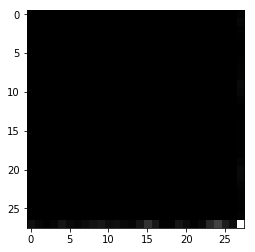

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.56it/s]

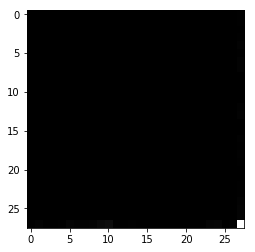

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.70it/s]

MODEL VERSION
200-batchsize_0.0001-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.720921e-35
Discriminator-Fake-Loss: 1.229675e-07
Discriminator Loss: 1.229675e-07
Generator Loss: 15.912259


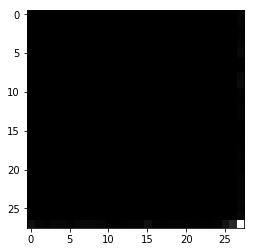

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.55it/s]

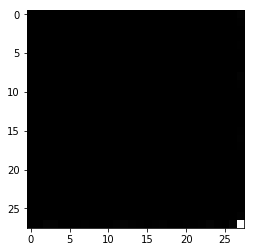

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.43it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.33443692
Discriminator-Fake-Loss: 0.0037207797
Discriminator Loss: 0.3381577
Generator Loss: 5.5936017


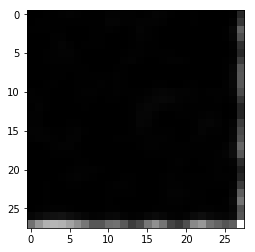

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.37it/s]

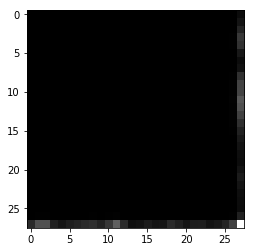

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:23, 17.48it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.33314666
Discriminator-Fake-Loss: 0.0039139804
Discriminator Loss: 0.33706063
Generator Loss: 5.5505633


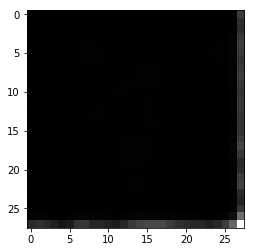

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.55it/s]

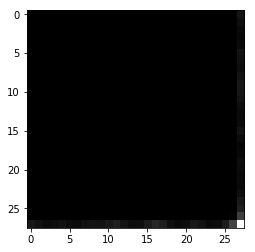

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.39it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32519573
Discriminator-Fake-Loss: 0.00025968943
Discriminator Loss: 0.32545543
Generator Loss: 8.2587385


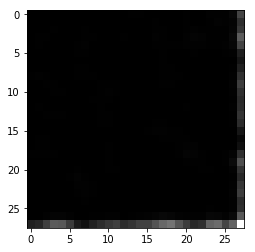

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.59it/s]

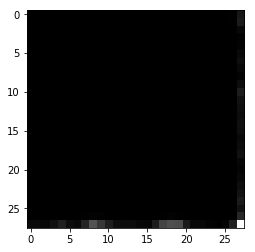

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:28, 16.88it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32512218
Discriminator-Fake-Loss: 0.0003392583
Discriminator Loss: 0.32546145
Generator Loss: 7.991431


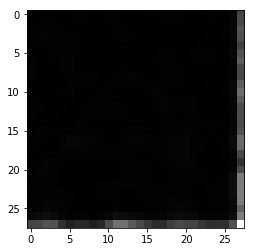

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.83it/s]

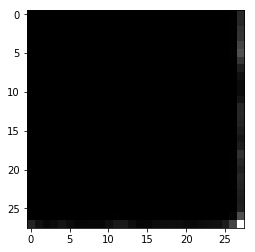

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.61it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.34015924
Discriminator-Fake-Loss: 0.0037947162
Discriminator Loss: 0.34395397
Generator Loss: 5.573328


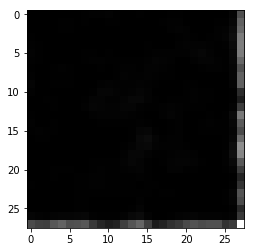

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.44it/s]

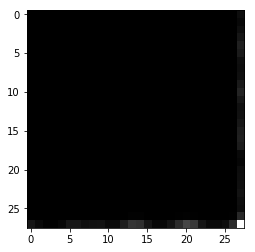

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:23, 17.48it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.33385006
Discriminator-Fake-Loss: 0.003816087
Discriminator Loss: 0.33766615
Generator Loss: 5.5763


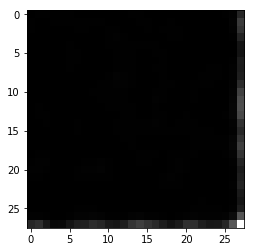

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.71it/s]

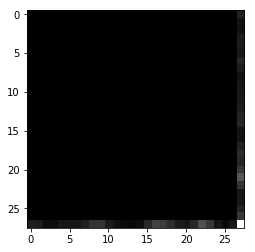

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.64it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32516152
Discriminator-Fake-Loss: 0.00024173677
Discriminator Loss: 0.32540324
Generator Loss: 8.330421


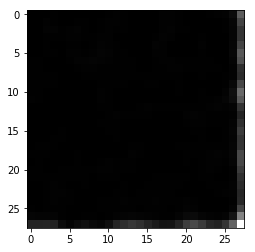

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.11it/s]

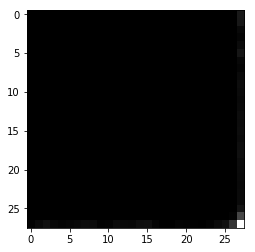

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.58it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32514927
Discriminator-Fake-Loss: 0.00028417457
Discriminator Loss: 0.32543343
Generator Loss: 8.169337


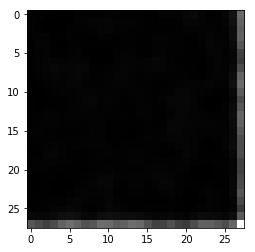

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.73it/s]

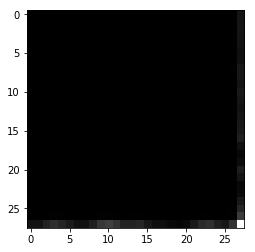

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.49it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 5.2836767e-05
Discriminator-Fake-Loss: 0.0006663352
Discriminator Loss: 0.000719172
Generator Loss: 7.3176374


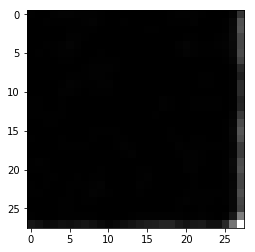

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.45it/s]

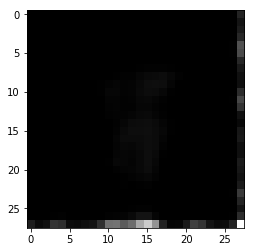

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:20, 17.81it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.0011274295
Discriminator-Fake-Loss: 0.001016917
Discriminator Loss: 0.0021443465
Generator Loss: 6.89304


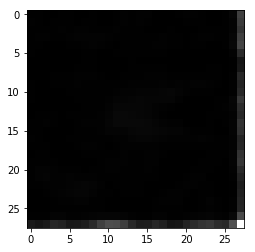

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.16it/s]

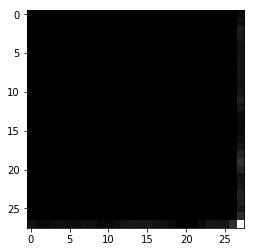

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:21, 17.70it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.5903093e-09
Discriminator-Fake-Loss: 0.0002328502
Discriminator Loss: 0.00023285279
Generator Loss: 8.367632


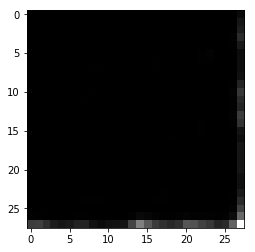

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.40it/s]

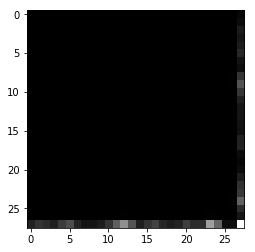

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:26, 17.05it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 2.9537567e-08
Discriminator-Fake-Loss: 0.00035811114
Discriminator Loss: 0.00035814068
Generator Loss: 7.9358807


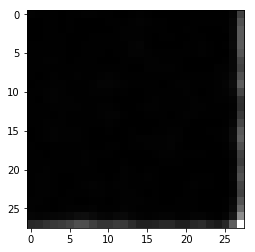

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.71it/s]

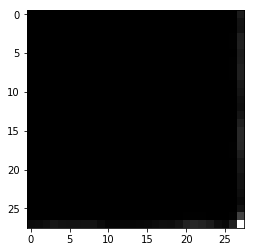

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.40it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.00017545166
Discriminator-Fake-Loss: 0.00085971295
Discriminator Loss: 0.0010351646
Generator Loss: 7.0625153


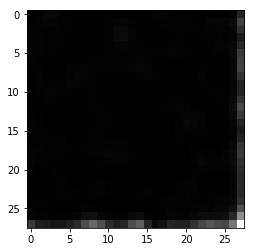

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.44it/s]

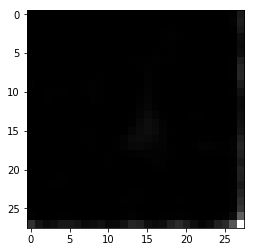

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.66it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.00017499046
Discriminator-Fake-Loss: 0.0007716056
Discriminator Loss: 0.00094659603
Generator Loss: 7.1703124


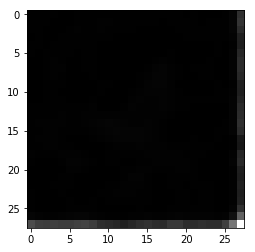

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.56it/s]

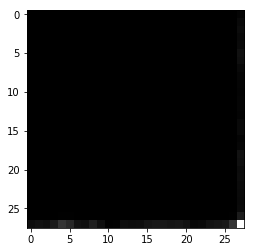

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.53it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.6414988e-09
Discriminator-Fake-Loss: 0.00018626491
Discriminator Loss: 0.00018626756
Generator Loss: 8.591303


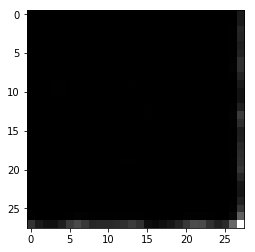

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 16.94it/s]

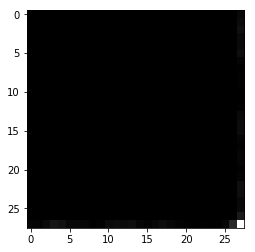

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:22, 17.62it/s]

MODEL VERSION
200-batchsize_1e-05-lr_1-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.8944634e-07
Discriminator-Fake-Loss: 0.000376942
Discriminator Loss: 0.00037713142
Generator Loss: 7.8859987


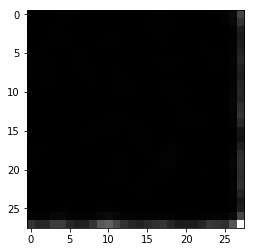

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.54it/s]

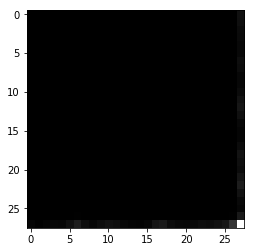

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.48it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32999983
Discriminator-Fake-Loss: 0.0013530911
Discriminator Loss: 0.33135292
Generator Loss: 6.611078


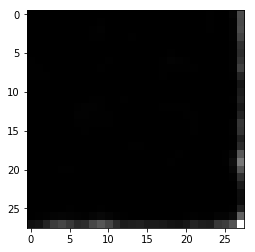

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.71it/s]

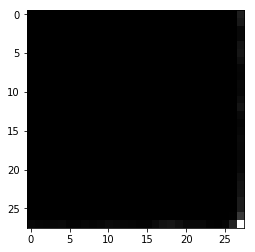

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:21, 17.71it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.33023372
Discriminator-Fake-Loss: 0.0017366179
Discriminator Loss: 0.33197033
Generator Loss: 6.3863792


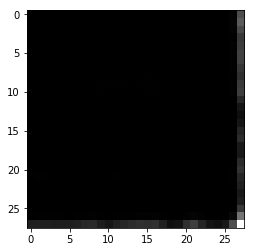

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:43<00:00, 17.57it/s]

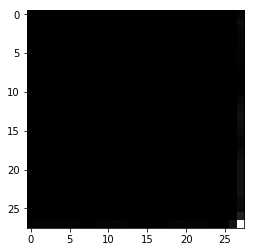

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:25, 17.24it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32510197
Discriminator-Fake-Loss: 1.9422201e-05
Discriminator Loss: 0.3251214
Generator Loss: 10.853628


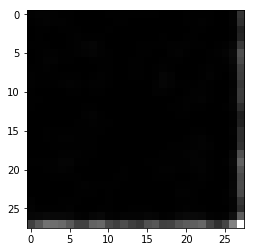

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.53it/s]

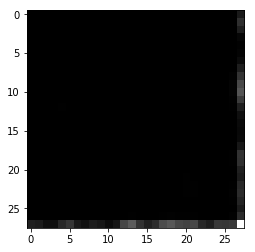

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.50it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32510227
Discriminator-Fake-Loss: 1.8726356e-05
Discriminator Loss: 0.325121
Generator Loss: 10.890742


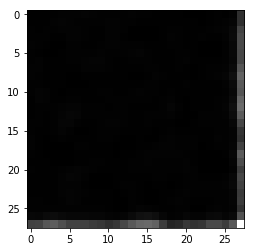

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.75it/s]

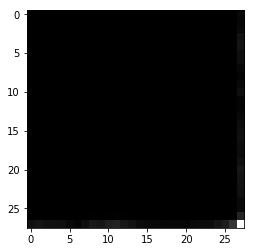

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:25, 17.18it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.32826674
Discriminator-Fake-Loss: 0.0011076119
Discriminator Loss: 0.32937434
Generator Loss: 6.820155


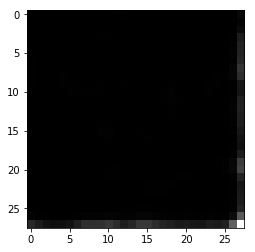

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.39it/s]

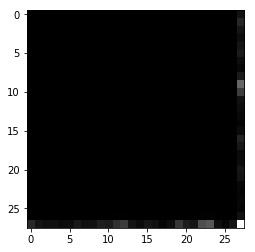

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:21<02:20, 17.86it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.3308095
Discriminator-Fake-Loss: 0.0017349374
Discriminator Loss: 0.33254445
Generator Loss: 6.351142


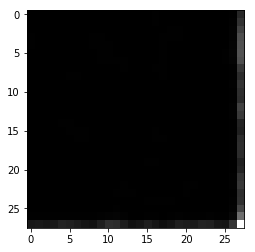

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:44<00:00, 17.66it/s]

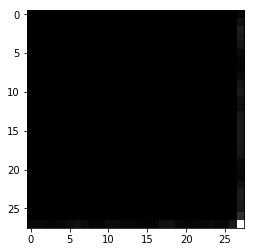

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.61it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 0.3251093
Discriminator-Fake-Loss: 1.2548055e-05
Discriminator Loss: 0.32512185
Generator Loss: 11.28912


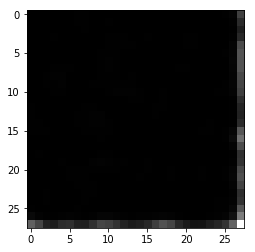

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.15it/s]

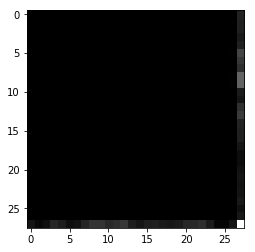

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.47it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_0.9-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 0.32510522
Discriminator-Fake-Loss: 1.0373864e-05
Discriminator Loss: 0.3251156
Generator Loss: 11.47954


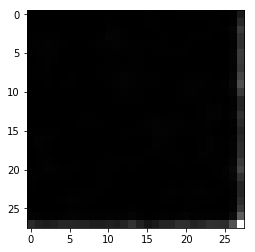

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.63it/s]

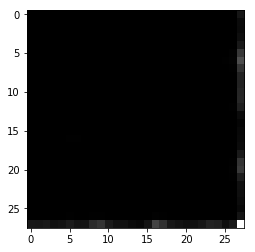

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:23<02:21, 17.66it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 2.9447413e-06
Discriminator-Fake-Loss: 5.846155e-05
Discriminator Loss: 6.1406296e-05
Generator Loss: 9.755419


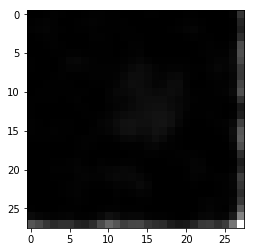

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:47<00:00, 17.54it/s]

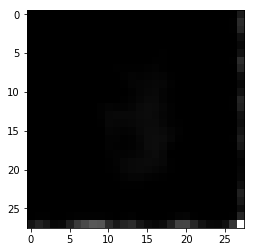

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:23, 17.47it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.10848505e-05
Discriminator-Fake-Loss: 7.195254e-05
Discriminator Loss: 8.303739e-05
Generator Loss: 9.548137


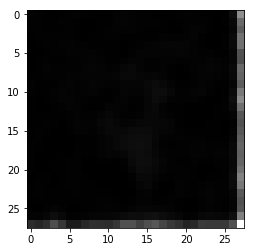

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.56it/s]

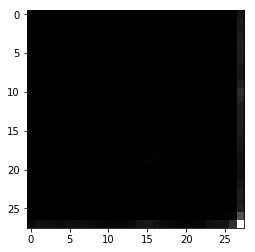

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:23<02:23, 17.44it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 1.4948304e-14
Discriminator-Fake-Loss: 1.9274707e-05
Discriminator Loss: 1.9274707e-05
Generator Loss: 10.853947


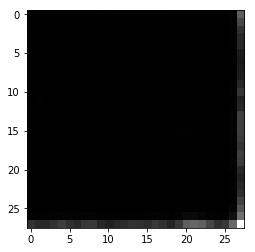

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.55it/s]

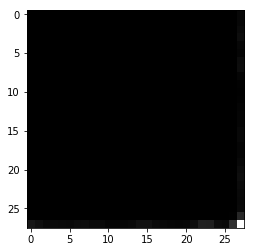

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.58it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_False-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.2090968e-11
Discriminator-Fake-Loss: 2.171143e-05
Discriminator Loss: 2.1711443e-05
Generator Loss: 10.7413845


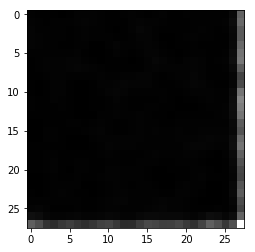

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.43it/s]

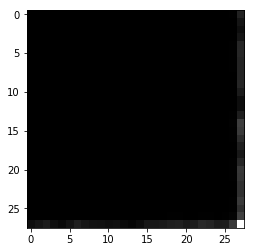

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:23<02:22, 17.60it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_False-uniformSamples
Discriminator-Real-Loss: 1.7538396e-06
Discriminator-Fake-Loss: 5.621647e-05
Discriminator Loss: 5.7970312e-05
Generator Loss: 9.795384


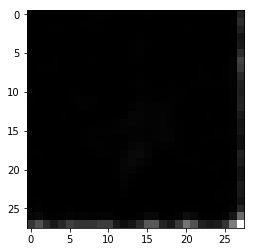

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:47<00:00, 17.67it/s]

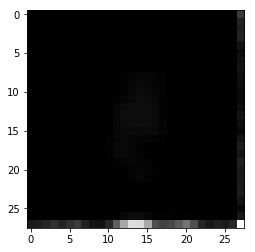

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:22, 17.51it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_False-tanh_True-uniformSamples
Discriminator-Real-Loss: 3.2133772e-05
Discriminator-Fake-Loss: 7.6249795e-05
Discriminator Loss: 0.00010838357
Generator Loss: 9.488772


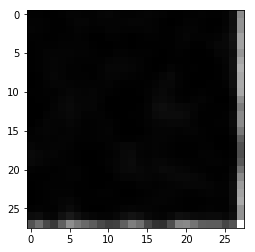

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.25it/s]

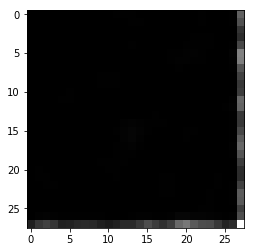

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:23<02:22, 17.61it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_False-uniformSamples
Discriminator-Real-Loss: 4.3610487e-14
Discriminator-Fake-Loss: 2.5233867e-05
Discriminator Loss: 2.5233867e-05
Generator Loss: 10.590891


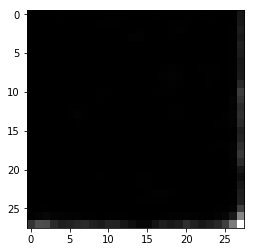

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:46<00:00, 17.48it/s]

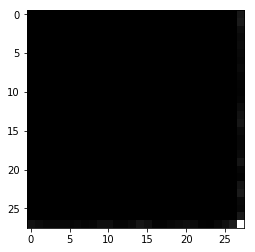

 50%|██████████████████████████████████████▉                                       | 2498/5000 [02:22<02:20, 17.77it/s]

MODEL VERSION
200-batchsize_1e-05-lr_3-discMultiplier_1-smoothing_True-leakyRelu_True-tanh_True-uniformSamples
Discriminator-Real-Loss: 1.2424567e-12
Discriminator-Fake-Loss: 1.6549287e-05
Discriminator Loss: 1.654929e-05
Generator Loss: 11.01187


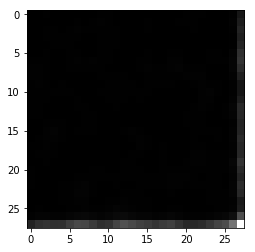

100%|█████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [04:45<00:00, 17.55it/s]

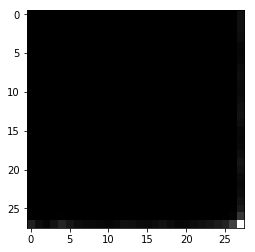

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:45<00:00,  8.88it/s]


In [24]:
with tf.Session(config=config) as sess:
    
    # For each Model
    for model in modes:   
        #Initialize Global Variables
        sess.run(init)
        
        # Save current model Parameters to individiual Variables
        current_batchSize = model[0]
        current_learningRate = model[1]
        current_discMultiplier = model[2]
        current_smoothingFactor = model[3]
        current_useLeaky = model[4]
        current_usetanh = model[5]
        current_useUniformDistribution = model[6]
        
        # Specify the data according to the current_usetanh variable
        if current_usetanh:
            current_data=batchtrain_tanh
        else:
            current_data=batchtrain
        
        # Calculate the Epochs to train a specific number of images
        EPOCHS = int((IMAGES)/current_batchSize)
        
        # Adding a descriptive String for the model
        model_text = "{0}-batchsize_{1}-lr_{2}-discMultiplier_{3}-smoothing_{4}-leakyRelu_{5}-tanh_{6}-uniformSamples".format(
            current_batchSize, current_learningRate, current_discMultiplier, current_smoothingFactor, current_useLeaky, current_usetanh, current_useUniformDistribution)
        
        # Naming the different Tensorboards. Additionally to the date, we added a shot description of the current model
        writer = tf.summary.FileWriter('./tensorboard/{0}_GAN-{1}'.format(now.strftime("%Y_%m_%d-%H-%M"), model_text), sess.graph)

        # Initialize the iterator for the Batch Size Variable and the Data used.
        sess.run(iterator.initializer, feed_dict={BATCH_SIZE:current_batchSize, data:current_data})
        
        # Pretrain Epochs for Discriminator. For 20000 images we need 200 Epochs with a batch size of 100
        for pretrain in tqdm(range(int(20000/current_batchSize))):
            # get next batch of images
            batch_images = sess.run(nextbatch)

            # We used random normal distribution with standard deviation of 0.5 -> Explanation below
            if current_useUniformDistribution:
                batch_z =  np.random.uniform(-1, 1, size=(current_batchSize,100))
            else:
                batch_z =  np.random.normal(0.0, 1, size=(current_batchSize,100))

            _ = sess.run(D_trainer, feed_dict={real_images:batch_images, z:batch_z, D_learning_rate:current_learningRate*current_discMultiplier, SMOOTHING: current_smoothingFactor, leaky_relu:current_useLeaky})

        # Training Epochs of GAN
        for epoch in tqdm(range(EPOCHS)):
            
            # get next batch of images
            batch_images = sess.run(nextbatch)

            # Differantiate between normal distributed random noise and uniform distributed according to the model variable current_useUniformDistribution
            if current_useUniformDistribution:
                batch_z =  np.random.uniform(-1, 1, size=(current_batchSize,100))
            else:
                batch_z =  np.random.normal(0.0, 1, size=(current_batchSize,100))

            # Train Discriminator
            D_summary, _, discrloss, discr_r_loss, discr_f_loss = sess.run([merged, D_trainer, D_loss, D_real_loss, D_fake_loss], feed_dict={real_images:batch_images, z:batch_z, D_learning_rate:current_learningRate*current_discMultiplier, SMOOTHING: current_smoothingFactor, leaky_relu:current_useLeaky})
            
            # Train Generator
            genloss, _ = sess.run([G_loss, G_trainer], feed_dict={z:batch_z, G_learning_rate:current_learningRate, leaky_relu:current_useLeaky})

            # For each 20 epochs write summary for Tensorboard
            if (epoch % 20 == 0):{
                # SUMMARIES
                writer.add_summary(D_summary, epoch)      
            }

            # At 50% and 100% of Epochs reached
            if ((epoch+1)%(EPOCHS/2)==0):

                # Differantiate between normal distributed random noise and uniform distributed according to the model variable current_useUniformDistribution
                if current_useUniformDistribution:
                    sample_z =  np.random.uniform(-1, 1, size=(1,100))
                else:
                    sample_z =  np.random.normal(0.0, 1, size=(1,100))
                
                # At 50% mark print out 
                if (epoch+1 == EPOCHS/2):
                    print("MODEL VERSION")
                    print(model_text)
                    
                    # Print out all losses -> Should have been written at both 50% and 100% Marks
                    print("Discriminator-Real-Loss:", discr_r_loss)

                    print("Discriminator-Fake-Loss:", discr_f_loss)

                    print("Discriminator Loss:",discrloss)

                    print("Generator Loss:",genloss)

                # Generate a sample image
                gen_sample = sess.run(gen(z, reuse_vars=True), feed_dict={z: sample_z, leaky_relu:current_useLeaky})
                
                # Display the sample image at current epoch
                plt.imshow(gen_sample.reshape(28,28), cmap="gray")
                plt.show()



# Evaluation & Conclusion

We have tested out 128 different models (7 hyperparameters with each containing 2 values).  

From those 128 models only 9 models succeeded in generating images.

#### Discriminator Loss - All 128 Models
![](img/ALL_D_loss.svg) 

#### Generator Loss - All 128 Models
![](img/ALL_G_loss.svg) 


As we can see most models do not converge. This can be observed in the Discriminator Loss, if the loss stays at a low value and at the generator, if the if the loss keeps rising

The Jump from 0.0 to 0.32 in the discriminator can be explained be the use of Smoothing.

We can also see that only one of the models with a smoothing of 1 was able to generate images. All of the other models used a smoothing factor of 0.9

## Working Models

For clearity we removed all the non working models from the chart.

These models are:

#### Discriminator Loss - All woriking Models
![](img/Good_D_loss.svg) 

* **LONGER ORANGE LINE**  
batchsize: 100 | learnrate: 0.0001 | Discriminator Multiplier: 1 | Smoothing: 0.9 | LeakyRelu: False | Tanh: False | UniformSamples: False

* **LONGER DARK BLUE LINE**  
batchsize: 100 | learnrate: 0.0001 | Discriminator Multiplier: 1 | Smoothing: 0.9 | LeakyRelu: False | Tanh: False | UniformSamples: True

* **LONGER RED LINE**  
batchsize: 100 | learnrate: 0.0001 | Discriminator Multiplier: 1 | Smoothing: 1 | LeakyRelu: True | Tanh: False | UniformSamples: False

* **LONGER LIGHT BLUE LINE**  
batchsize: 100 | learnrate: 0.0001 | Discriminator Multiplier: 3 | Smoothing: 0.9 | LeakyRelu: False | Tanh: False | UniformSamples: False

* **SHORTER PINK LINE**  
batchsize: 200 | learnrate: 0.0001 | Discriminator Multiplier: 1 | Smoothing: 0.9 | LeakyRelu: False | Tanh: False | UniformSamples: False

* **SHORTER DARK GREEN LINE**  
batchsize: 200 | learnrate: 0.0001 | Discriminator Multiplier: 1 | Smoothing: 0.9 | LeakyRelu: True | Tanh: False | UniformSamples: False

* **SHORTER GREY LINE**  
batchsize: 200 | learnrate: 0.0001 | Discriminator Multiplier: 1 | Smoothing: 0.9 | LeakyRelu: True | Tanh: False | UniformSamples: True

* **SHORTER ORANGE LINE**  
batchsize: 200 | learnrate: 0.0001 | Discriminator Multiplier: 3 | Smoothing: 0.9 | LeakyRelu: True | Tanh: False | UniformSamples: False








#### Generator Loss - All woriking Models
![](img/Good_G_loss.svg) 



# Observations
As mentioned above, we can see that only one model starts at a loss value of around 0. All other models are starting a a little above 0.3. This can be explained by taking a look at the model. The one model starting at 0 is the only working model that uses a smoothing of the Discriminator Loss.  

Some Models have a longer line and some have a shorter line. This can be explained by the different batch sizes. Shorter Batch Size only have half as much EPOCHS. For this demonstration we used a relative horizontal axis instead of a step-wise demonstration of the x-axis. Why they do not exactly match must still be investigated. Perhaps there is an error in the implementation / Calculation of EPOCHS in regard of the Batch Size.  

We can yet again see, that each model takes some time until it kicks of with generating "good" images. This exact moment can be seen in each model. It is the moment, when the Discriminator loss begins to rise. Before this moment, the discriminator loss value seems to be nearly constant at the starting level.  

Each starting point varies. They also no significant correlation between the starting point and the quality of the generator.
For example, the light blue model is the first model to reach this starting point however, has the lowest end discriminator loss. The third model to reach the starting point, the orange one, has the highest end discriminator loss value.

**Now let's take a look at the model parameters:**  
First we can clearly see, that only models with a learning rate of 0.0001 have generated digits. All models with the learning rate of 0.00001 have failed to generate digits.  

It is interesting to see that there are exaclty 4 models with a batch size of 100 and 4 models with a batch size of 200. But other than that there is no recommendation between using a batch size of 100 or 200. It seems as if the Model with a larger Batch size is training a little bit faster.

>Training Time for batch Size 100 (LONGER ORANGE LINE): 05:19  
Training Time for batch Size 200 (SHORTER PINK LINE): 04:46

With the Discriminator Multiplier no distinct explanation can be made. We can see that there are two models that work with a Multiplication of 3. The other 6 models work with same Learning Rates for the Discriminator and Generator. Perhaps with a higher starting learning rate of 0.001, this could have a greater effect.

As stated above, only one model with no smoothing generated images. Therefore we recommend using Smoothing to improve the GAN

As for our Boolean Operations Leaky Relu & Uniform Distributed Random:  
 
For Leaky Real it seems as if using a batch size of 200 and leaky relu perform better. But to be honest, we would need more evidence to support this thesis

For the Tanh Boolean Operation, we can clearly see, that only models using the sigmoid function actually work.
We should double check that the implementation of the Tanh activation function is correctly implemented. 

# Next Steps & Conclusion

A next step should definately be to redo this exact same implementation to see if only those 8 models generate images or if it is just a random selection wheather or not exactly these 8 models produce images.
Until now it seems rather random.

Since only 6,25% of the models generated images, it is hard to say what parameters are actually improving the model or not.

As for the produced images, some have generated acceptable images and others have produced not so good examples. But compared to the model from the first paper 01-GAN they have all generated images of different digits. This is most likely due to the use of random values between -1 and 1 (uniformely distributed or normally distributed)


Further things to test out:
* Add Dropout to the models
* **Use Batch Normalization** or not
* **Pretrain the Discriminator** and specify how many images **(20000)** or not
* generate specific digits by including the datalabels or **generate random digits**
* try out more | less complex models (especially the discriminator)
* try out different Loss functions (GAN | LSGAN | WGAN | CGAN | BEGAN | ACGAN | ...)
* try out Varational Auto Encoders


We have worked on another Jupyter Notebook implementing the WGAN Loss Function. 
> 03-WGAN


# References

<sup>[1]</sup> [Tensorflow Documentation](https://www.tensorflow.org/api_docs/python)   
<sup>[2]</sup> [Udemy Tutorial](https://www.udemy.com/complete-guide-to-tensorflow-for-deep-learning-with-python/learn/lecture/8410116?start=0#overview)   
<sup>[3]</sup> [GAN — Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)  
<sup>[4]</sup> [Vanilla GAN implementation](https://github.com/taki0112/GAN-Tensorflow/blob/master/Vanilla_GAN.py)   
<sup>[5]</sup> [Implementing a Generative Adversarial Network (GAN/DCGAN) ](https://towardsdatascience.com/implementing-a-generative-adversarial-network-gan-dcgan-to-draw-human-faces-8291616904a)  
<sup>[6]</sup> [Using labels to improve GANs](https://medium.com/@jonathan_hui/gan-cgan-infogan-using-labels-to-improve-gan-8ba4de5f9c3d)  
<sup>[7]</sup> [VAE](https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776)  